In [2]:
import keras.backend as kk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nibabel.testing import data_path
import os
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import segmentation_models as sm
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss
from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow
from nilearn.image import resample_img
from sklearn.model_selection import train_test_split
import random
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
from nipype.interfaces.ants import N4BiasFieldCorrection
import keras


Segmentation Models: using `keras` framework.


In [3]:
import tensorflow as tf
from keras.layers import Conv3D,BatchNormalization,Activation,MaxPooling3D,Dropout,Conv3DTranspose,concatenate,Input
from keras import optimizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from focal_loss import BinaryFocalLoss
from tensorflow import keras
from keras import layers
from keras import metrics
from keras import losses

In [4]:
import os
brain_mask=[]
brain=[]
raw=[]
for subdir, dirs, files in os.walk(r"C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFBS_Dataset"):
    for file in files:
        #print os.path.join(subdir, file)y
        filepath = subdir + os.sep + file

        if filepath.endswith(".gz"):
            if '_brainmask.' in filepath:
                brain_mask.append(filepath)
            elif '_brain.' in filepath:
                brain.append(filepath)
            else:
                raw.append(filepath)

In [5]:
data=pd.DataFrame({'brain_mask':brain_mask,'brain':brain,'raw':raw})
data.head()

,brain_mask,brain,raw
0,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...
1,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...
2,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...
3,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...
4,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...,C:\Users\luhar\SIH 2022\Data2\NFBS_Dataset\NFB...


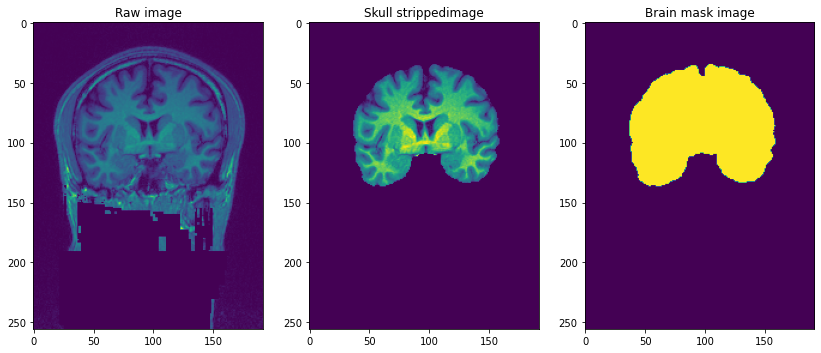

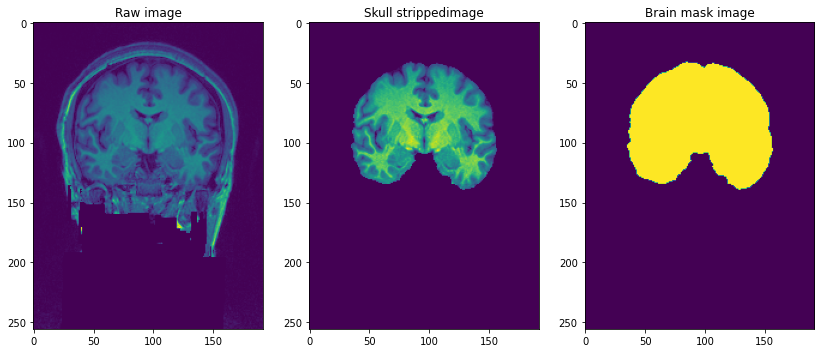

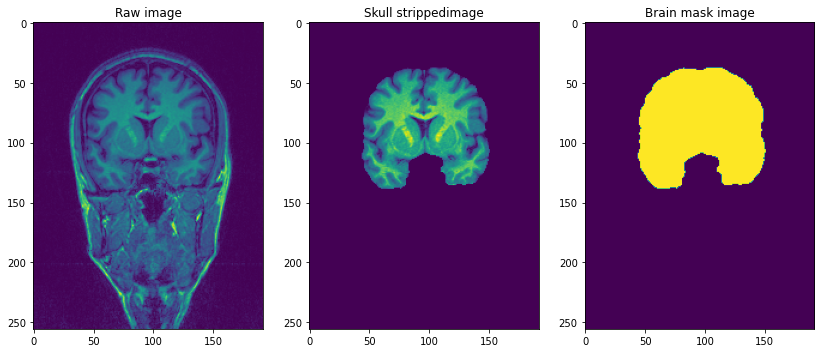

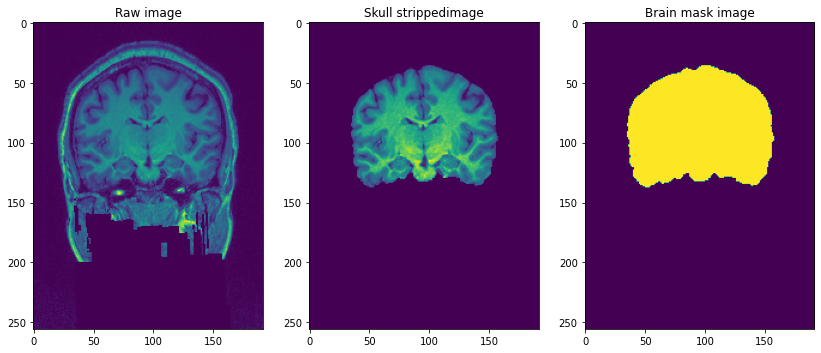

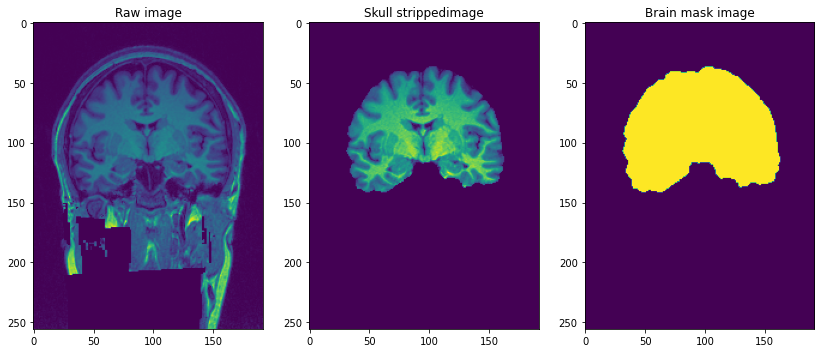

In [6]:
#lets visualize a couple of examples
for i in range(5):
    fig,ax=plt.subplots(1,3,figsize=(14,10))
    ax[0].set_title('Raw image')
    img = nib.load(data.raw.iloc[i]).get_data()
    ax[0].imshow(img[img.shape[0]//2])
    ax[1].set_title('Skull strippedimage')
    img = nib.load(data.brain.iloc[i]).get_data()
    ax[1].imshow(img[img.shape[0]//2])
    ax[2].set_title('Brain mask image')
    img = nib.load(data.brain_mask.iloc[i]).get_data()
    ax[2].imshow(img[img.shape[0]//2])

In [8]:
raw_index=[]
mask_index=[]

In [9]:
def bias_correction(data,raw_index,mask_index):
    
    n4 = N4BiasFieldCorrection()
    n4.inputs.dimension = 3
    n4.inputs.shrink_factor = 3
    n4.inputs.n_iterations = [20, 10, 10, 5]
    index_corr=[]
    for i in tqdm(range(len(data))):
        n4.inputs.input_image = data.raw.iloc[i]
        n4.inputs.output_image ='bias_correction/'+str(i)+'.nii.gz'
        index_corr.append('bias_correction/'+str(i)+'.nii.gz')
        res = n4.run()
    index_corr=['bias_correction/'+str(i)+'.nii.gz' for i in range(125)]
    data['bias_corr']=index_corr
    print('Bias corrected images stored at : bias_correction/')

In [10]:
def resize_crop(data,raw_index,mask_index):
    #Reducing the size of image due to memory constraints
    
    target_shape = np.array((96,128,160))                   #reducing size of image from 256*256*192 to 96*128*160
    new_resolution = [2,]*3
    new_affine = np.zeros((4,4))
    new_affine[:3,:3] = np.diag(new_resolution)
    # putting point 0,0,0 in the middle of the new volume - this could be refined in the future
    new_affine[:3,3] = target_shape*new_resolution/2.*-1
    new_affine[3,3] = 1.
    raw_index=[]
    mask_index=[]
    #resizing both image and mask and storing in folder
    for i in range(len(data)):
        downsampled_and_cropped_nii = resample_img(data.bias_corr.iloc[i], target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
        downsampled_and_cropped_nii.to_filename('resized/raw'+str(i)+'.nii.gz')
        raw_index.append('resized/raw'+str(i)+'.nii.gz')
        downsampled_and_cropped_nii = resample_img(data.brain_mask.iloc[i], target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
        downsampled_and_cropped_nii.to_filename('resized/mask'+str(i)+'.nii.gz')
        mask_index.append('resized/mask'+str(i)+'.nii.gz')
    return raw_index,mask_index

In [11]:
def intensity_normalization(data,raw_index,mask_index):
    for i in raw_index:
        image = sitk.ReadImage(i)
        resacleFilter = sitk.RescaleIntensityImageFilter()
        resacleFilter.SetOutputMaximum(255)
        resacleFilter.SetOutputMinimum(0)
        image = resacleFilter.Execute(image)
        sitk.WriteImage(image,i)
    print('Normalization done. Images stored at: resized/')

In [13]:
bias_corrected=bias_correction(data,raw_index,mask_index)

  0%|                                                                                          | 0/125 [00:00<?, ?it/s]


OSError: No command "N4BiasFieldCorrection" found on host TheLuharukas. Please check that the corresponding package is installed.

In [1]:
from dipy.tracking.utils import density_map
tract_density=density_map()